## <center> Stock trading using Deep Q Learning agent </center>

Reinforcement learning model using Deep Quality Network (DQN) is used to predict stock prices. It is applied to three different stocks to check its capabilities 

In [1]:
# imports
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import copy

import torch
from torch import nn,optim
import torch.nn.functional as F

import pandas as pd

from IPython.display import clear_output

In [2]:
# checking cuda gpu availability
torch.cuda.is_available()

False

<h3>Class for setting up environment</h3>

In [3]:
# setup environment
class stockMarket():
    
    # static variables (class variables)
    BUY = 0
    SELL = 1
    NEUTRAL = 2
    
    def __init__(self, data, budget, max_buys_before_sell = 3, width_of_state = 10):
        
        # saving all variables as they are passed to the constructor to use in reset method
        self.starting_budget = budget
        self.starting_max_buys_before_sell = max_buys_before_sell
        self.starting_width_of_state = width_of_state
        
        # assigning variable values to instance variables
        self.data = data
        self.budget = budget
        self.max_buys_before_sell = max_buys_before_sell
        self.width_of_state = width_of_state
        
        self.initialize_starting_state()
    
    
    def initialize_starting_state(self):
        self.buy_count = 0
        self.owned_stocks = 0
        self.isDone = False
        
        # pointer points to the last data point available at the current step
        self.pointer = self.width_of_state - 1
        
        # this variable is used to compute profit after selling
        self.budget_just_after_previous_sell = budget
        
        # initializing state
        # state contains few previous data points, budget, remaining buy chances, owned stocks in the same order
        self.state = [self.data[i] for i in range(self.width_of_state)]
        self.state.append(self.budget)
        self.state.append(self.max_buys_before_sell - self.buy_count)
        self.state.append(self.owned_stocks)
    
    
    def reset(self):
        self.budget = self.starting_budget
        self.max_buys_before_sell = self.starting_max_buys_before_sell
        self.width_of_state = self.starting_width_of_state
        
        self.initialize_starting_state()
        
        
    def take_action(self, action):
        # 0 to buy, 1 to sell, 2 to remain neutral
        reward_for_cur_action = 0

        if action == stockMarket.BUY:
            if (self.budget > 0 and self.buy_count < self.max_buys_before_sell):
                
                amount = self.budget / (self.max_buys_before_sell - self.buy_count)
                cur_price_per_stock = self.data[self.pointer]
                
                self.budget = self.budget - amount
                self.owned_stocks += amount/cur_price_per_stock
                self.buy_count += 1

                # calculate reward for not giving sell signal
                reward_for_not_selling = self.owned_stocks*(self.data[self.pointer + 1] - self.data[self.pointer])
                
                reward_for_buying = amount*((self.data[self.pointer + 1]/self.data[self.pointer]) - 1)
                
                # total reward for current action
                reward_for_cur_action = reward_for_not_selling + reward_for_buying

        elif action == stockMarket.SELL:
            if self.owned_stocks > 0:
                
                # calculate reward for not giving buy signal
                if self.buy_count < self.max_buys_before_sell:
                    amount_to_buy_with = self.budget/(self.max_buys_before_sell - self.buy_count)
                    reward_for_not_buying = amount_to_buy_with*(1 - (self.data[self.pointer + 1]/self.data[self.pointer]))
                else:
                    reward_for_not_buying = 0

                # reward for giving sell signal at this current point
                reward_for_selling_now = self.owned_stocks * (self.data[self.pointer] - self.data[self.pointer + 1])

                # performing selling operation
                self.budget = self.budget + self.owned_stocks * self.data[self.pointer]
                self.owned_stocks = 0
                self.buy_count = 0
                
                # profit obtained
                profit_obtained = self.budget - self.budget_just_after_previous_sell
                self.budget_just_after_previous_sell = self.budget

                reward_for_cur_action = reward_for_not_buying + reward_for_selling_now + profit_obtained

        elif action == stockMarket.NEUTRAL:
            # calculate reward for not giving buy signal
            if self.buy_count < self.max_buys_before_sell:
                amount_to_buy_with = self.budget/(self.max_buys_before_sell - self.buy_count)
                reward_for_not_buying = amount_to_buy_with*(1 - (self.data[self.pointer + 1]/self.data[self.pointer]))
            else:
                reward_for_not_buying = 0
            # calculate reward for not giving sell signal
            reward_for_not_selling = self.owned_stocks*(self.data[self.pointer + 1] - self.data[self.pointer])

            # total reward for being neutral
            reward_for_cur_action = reward_for_not_buying + reward_for_not_selling
            
        self.pointer += 1
        
        # if pointer is at the last data point, sell all the stocks and compute profit
        if self.pointer == len(self.data) - 1:
            self.isDone = True
            
            self.budget = self.budget + self.owned_stocks * self.data[self.pointer]
            self.owned_stocks = 0
            self.buy_count = 0
            reward_for_cur_action = self.budget - self.budget_just_after_previous_sell
            self.budget_just_after_previous_sell = self.budget
        
        # updating the state
        self.state = self.get_cur_state()
        
        return (self.state, reward_for_cur_action, self.isDone) # return next state, reward for the action, is done or not
            
            
    def get_overall_profit(self):
        return self.budget + (self.owned_stocks * self.data[self.pointer]) - self.starting_budget
    
    
    def get_all_actions(self):
        return [stockMarket.BUY, stockMarket.SELL, stockMarket.NEUTRAL]
    
    
    def get_cur_state(self):
        temp = [self.data[i] for i in range((self.pointer - (self.width_of_state - 1)), (self.pointer + 1))]
        temp.append(self.budget)
        temp.append(self.max_buys_before_sell - self.buy_count) # appending the remaining chances to make a purchase
        temp.append(self.owned_stocks) # appending the current portfolio
        
        return temp

<h3>Testing the 'stockMarket' class</h3>

Random actions are sent to the environment at each step and overall profit is plotted at every step. Overall proifts plot should be different for each time this block is executed as there is no fixed policy in action here.

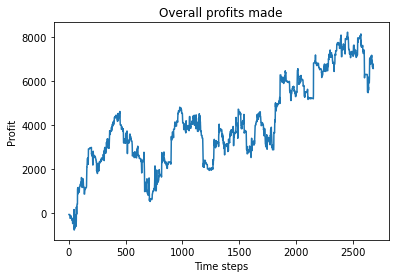

In [4]:
# first extract the necessary data ( get adjusted closing prices in a list)
stock_data = pd.read_csv(r"./stock_info/SBIN.NS.csv")
stock_data.dropna(subset = ['Adj Close'], inplace = True)
data = list(stock_data['Adj Close'])

# set budget
budget = 10000

# setup environment
env = stockMarket(data, budget)

overall_profit = []
env.reset()

for i in range(len(data)):
    _, _, isDone = env.take_action(random.choice(env.get_all_actions()))
    overall_profit.append(env.get_overall_profit()) # current budget + portfolio value from market - initial budget
    if i%20 == 0:
        plt.plot(overall_profit)
        plt.xlabel('Time steps')
        plt.ylabel('Profit')
        plt.title('Overall profits made')
        plt.show()
        clear_output(wait=True)
    if isDone is True:
        break
env.reset()

<h3>Class for storing replay memory and providing random batch when necessary</h3>

In [5]:
# Replay memory class
class replayMemory():
    def __init__(self, replay_memory_size, batch_size):
        self.replay_memory_size = replay_memory_size
        self.batch_size = batch_size
        
        self.memory = []
        self.pointer = 0
        
    def add_exp(self, experience):
        """Adds one experience event to the list of replay memory"""
        if len(self.memory) < self.replay_memory_size:
            self.memory.append(experience)
        else:
            self.memory[self.pointer] = experience
            if self.pointer < (self.replay_memory_size - 1):
                self.pointer += 1
            else:
                self.pointer = 0
                
    def can_get_batch(self):
        """Lets you know if a batch of specified size can be obtained or not"""
        if len(self.memory) >= self.batch_size:
            return True
        else:
            return False
        
    def get_batch(self):
        """Returns a batch of specified size in numpy ndarray format"""
        return random.sample(self.memory, self.batch_size)

<h3>Agent class</h3>

This class takes training environment and validation environment. It practives and trains on training environment. Then it performs on validation environment without learning and gives the overall profit at each time step. Profit at final interval is the final profit earned after that trading session

In [6]:
class agent:

    def __init__(self, practice_environment, validation_environment):
        self.practice_environment = practice_environment
        self.validation_environment = validation_environment


    def practice_trading(self):
        """This method makes the agent practice on training environment"""

        env = self.practice_environment

        # set computing device, prefer cuda gpu
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # initializing hyper parameters
        replay_mem_size = 1000
        batch_size = 64

        num_episodes = 50

        epsilon = 1
        max_epsilon = 1
        min_epsilon = 0.01
        epsilon_decay_rate = 0.5

        learning_rate = 0.001
        discount_rate = 0.99

        # parameters for architecture of Deep Q Network
        input_size = len(env.get_cur_state())
        hidden_one_size = input_size*10
        hidden_two_size = input_size*2
        output_size = len(env.get_all_actions())

        # parameters for plotting
        moving_average_width = 5

        #initialize replay memory
        rep_mem = replayMemory(replay_mem_size, batch_size)

        # defining policy net and target net
        policy_net = nn.Sequential(nn.Linear(input_size, hidden_one_size),
                                nn.ReLU(),
                                nn.Linear(hidden_one_size, hidden_two_size),
                                nn.ReLU(),
                                nn.Linear(hidden_two_size, output_size))
        target_net = copy.deepcopy(policy_net)

        # set the selected device
        policy_net.to(device)
        target_net.to(device)

        target_net_reset_period = 10 # updates the weights of target net after these many steps every time

        # Mean squared error loss criterion and SGD regressor are declared
        criterion = nn.MSELoss().to(device)
        optimizer = optim.SGD(policy_net.parameters(), learning_rate)

        profit_in_all_episodes = []

        # starting episodes
        for episode in range(num_episodes):
            env.reset()
            
            isDone = False
            step_count = 0
        
            while isDone is False:
                step_count += 1
                cur_state = env.get_cur_state()
                
                # explore or exploit based on epsilon greedy policy
                if epsilon > random.uniform(0, 1):
                    action = random.choice(env.get_all_actions())
                else:
                    action = np.argmax(policy_net(torch.Tensor(env.get_cur_state()).to(device)).tolist())
                
                # taking the selected action
                next_state, reward, isDone = env.take_action(action)
            
                # adding the gained experience in the form of dictionary to the replay memory
                experience = {'state':cur_state, 'action':action, 'reward':reward, 'next_state':next_state}
                rep_mem.add_exp(experience)
                
                if isDone is True:
                    # if episode is over, update over all profit and break out
                    profit_in_all_episodes.append(env.get_overall_profit())
                    break
                
                if rep_mem.can_get_batch() is True:
                    # take a batch
                    batch = rep_mem.get_batch()
                    
                    # process the batch data to get individual column data as tensors
                    data_frame = pd.DataFrame(batch)
                    states = torch.Tensor(data_frame['state']).to(device)
                    actions = torch.Tensor(data_frame['action']).to(device)
                    rewards = torch.Tensor(data_frame['reward']).to(device)
                    next_states = torch.Tensor(data_frame['next_state']).to(device)

                    policy_net.train()
                    
                    # gathering q values of selected states only
                    actions = actions.to(torch.int64)
                    q_values = policy_net(states).gather(dim = 1, index = actions.unsqueeze(-1))
                    next_q_values, _ = torch.max(target_net(next_states), dim = 1)
                    target_q_values = rewards.unsqueeze(-1) + discount_rate * next_q_values.unsqueeze(-1)

                    loss = criterion(q_values, target_q_values)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # train the model here using the batch taken
                    # loss is learning rate multiplied by (Q target net - Q policy net)
                    # for every few iterations, update target net
                    
                if step_count % target_net_reset_period == 0:
                    target_net.load_state_dict(policy_net.state_dict())
            
            # update epsilon using epsilon decay rate
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-1*episode*epsilon_decay_rate)
            
            # plotting overall profit in each iteration
            plt.plot(profit_in_all_episodes)
            
            # plotting moving averages
            moving_avg = pd.DataFrame(profit_in_all_episodes)
            moving_avg = moving_avg.rolling(window = moving_average_width).mean()
            moving_avg.columns = ['average']
            plt.plot(moving_avg['average'].fillna(0))
            
            plt.xlabel("Episode number")
            plt.ylabel("Overall profit")
            plt.title("Profit curve (initial budget = 10000)")
            plt.legend(['Profit', 'Moving average'])
            plt.show()
            print(episode)
            clear_output(wait = True)

            # saving policy net
            self.policy_net = policy_net


    def validate(self):
        """This method makes the model perform on the validation environment"""

        # set computing device, prefer cuda gpu
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        validation_env = self.validation_environment
        policy_net = self.policy_net

        policy_net.eval() # setting the policy net to evalution only mode

        validation_env.reset()

        isDone = False
        overall_profit_at_each_step = []

        while isDone is False:
            current_state = validation_env.get_cur_state()
            action = np.argmax(self.policy_net(torch.Tensor(current_state).to(device)).tolist())
            next_state, reward, isDone = validation_env.take_action(action)
            overall_profit_at_each_step.append(validation_env.get_overall_profit())
            if isDone is True:
                break

        plt.plot(overall_profit_at_each_step)
        plt.title("Overall profit at each time step")
        plt.xlabel("Time step")
        plt.ylabel("Overall profit")
        plt.show()
        print("Profit at the end of validation run is", overall_profit_at_each_step[len(overall_profit_at_each_step) - 1])

        validation_env.reset()

<h3>Method for 'stockMarket' environment setup and data visualization</h3>

In [7]:
def make_env(file_path, train_validation_split_date, budget):
    # first extract the necessary data (get adjusted closing prices in a list)
    stock_data = pd.read_csv(file_path) # reading csv file
    stock_data.dropna(subset = ['Adj Close'], inplace = True) # drop non numeric values

    train_data = stock_data.loc[stock_data['Date'] <= train_validation_split_date]
    validation_data = stock_data.loc[stock_data['Date'] > train_validation_split_date]

    # visualizing the data from data frame
    plt.plot(train_data['Adj Close'])
    plt.plot(validation_data['Adj Close'])
    plt.legend(['Training data', 'Validation data'])
    plt.xlabel("Time step")
    plt.ylabel("Stock price")
    plt.title("Visualizing data")
    plt.show()

    # convert both training and validation data sets from pandas series into lists
    train_data = list(train_data['Adj Close'])
    validation_data = list(validation_data['Adj Close'])

    # setup training and validation environments
    env = stockMarket(train_data, budget)
    valid_env = stockMarket(validation_data, budget)

    return (env, valid_env)

<h3>Example 1:</h3>

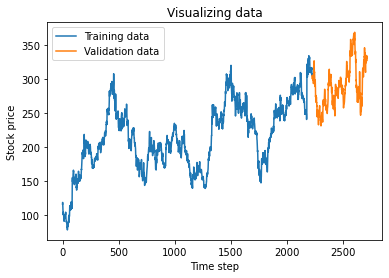

In [8]:
# prepare a testing environment and a validation environment and visualization
env_path = r"./stock_info/SBIN.NS.csv"
split_date = '2017-12-31'
budget = 10000
env, valid_env = make_env(env_path, split_date, budget)

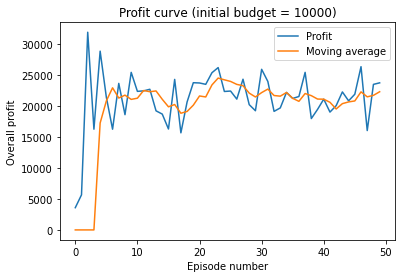

49


In [9]:
a1 = agent(env, valid_env)
a1.practice_trading()

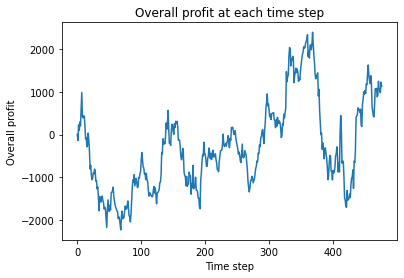

Profit at the end of validation run is 1135.3852244687587


In [10]:
a1.validate()

<h3>Example 2:</h3>

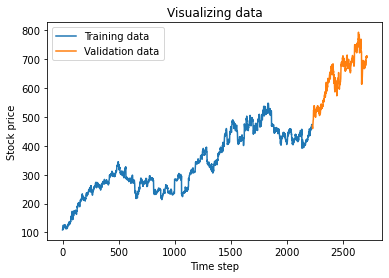

In [11]:
# prepare a testing environment and a validation environment and visualization
env_path = r"./stock_info/INFY.NS.csv"
split_date = '2017-12-31'
budget = 10000
env, valid_env = make_env(env_path, split_date, budget)

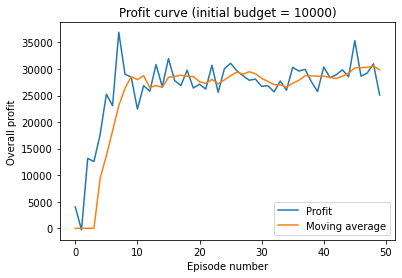

49


In [12]:
a2 = agent(env, valid_env)
a2.practice_trading()

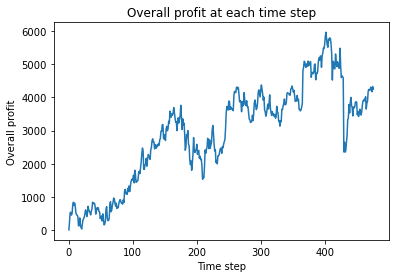

Profit at the end of validation run is 4247.012900764277


In [13]:
a2.validate()

<h3>Example 3:</h3>

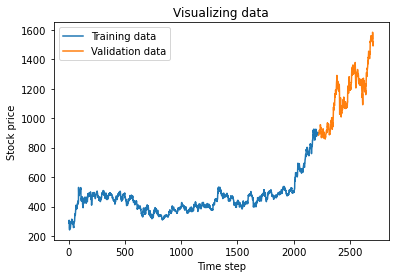

In [15]:
# prepare a testing environment and a validation environment and visualization
env_path = r"./stock_info/RELIANCE.NS.csv"
split_date = '2017-12-31'
budget = 10000
env, valid_env = make_env(env_path, split_date, budget)

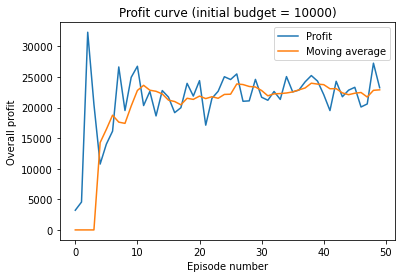

49


In [16]:
a3 = agent(env, valid_env)
a3.practice_trading()

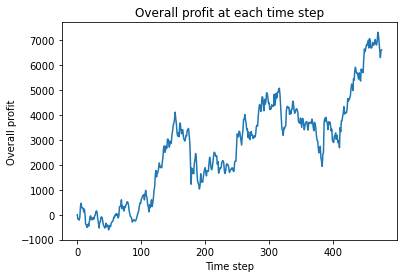

Profit at the end of validation run is 6616.896494661556


In [17]:
a3.validate()